# Выбор региона для разработки новых нефтяных месторождений

## Введение

Целью данного проекта является разработка модели для определения региона, где добыча нефти принесёт наибольшую прибыль. 

Условия задачи:

1) Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

2) При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

3) Бюджет на разработку скважин в регионе — 10 млрд рублей.

4) При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

5) После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Описание данных

Данные представляют собой пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов (данные синтетические: детали контрактов и характеристики месторождений не разглашаются). 

Данные геологоразведки трёх регионов находятся в файлах:
- `/datasets/geo_data_0.csv`;
- `/datasets/geo_data_1.csv`;
- `/datasets/geo_data_2.csv`.

где `id — уникальный идентификатор скважины;`

    `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
    
    `product` — объём запасов в скважине (тыс. баррелей).

## План проекта

1) [Загрузим и подготовим данные.](#1)

2) [Обучим и проверим качество модели линейной регрессии для каждого региона:](#2)

- Разобьем данные на обучающую и тестовую выборки в соотношении 4:1.
- Обучим модель и сделаем предсказания на тестовой выборке.
- Посчитаем средний запас предсказанного сырья и RMSE модели.
- Проведем анализ результатов.

3) [Выполним подготовку к расчету прибыли.](#3)


5) [Посчитаем риски и прибыль для каждого региона:](#4)

- Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.
- Предложим регион для разработки скважин.

6) [Напишем общий вывод.](#5)

## Ипользуемые библиотеки в проекте

- `pandas`;
- `warnings`;
- `IPython`;
- `NumPy`;
- `scipy`;
- `matplotlib`;
- `seaborn`;
- `sklearn`;

## Загрузка и подготовка данных<a id='1'></a>

Установка библиотек:

In [1]:
!pip install seaborn -U

Импортируем необходимые для работы библиотеки:

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression

Импортируем геоданные в соответствующие датафреймы: `df_geo_0`, `df_geo_1`, `df_geo_2`.

In [3]:
df_geo_0 = pd.read_csv(r'C:\Users\Wunderwaffe\Downloads\geo_data_0.csv')
df_geo_1 = pd.read_csv(r'C:\Users\Wunderwaffe\Downloads\geo_data_1.csv')
df_geo_2 = pd.read_csv(r'C:\Users\Wunderwaffe\Downloads\geo_data_2.csv')

Напишем функцию вывода основной информации о датафрейме:
- первые пять объектов датафрейма;
- информация о датафрейме методом `.info()`;
- проверка на дубликаты методом `.duplicated()` в сочетании с методом `.sum()`.

In [4]:
def info_dataframe(df):
    print('Первые пять объектов датафрейма:')
    display(df.head())
    print('Информация о датафрейме:')
    display(df.info())
    print('Число явных дубликатов в датафрейме: ', df.duplicated().sum())

In [5]:
info_dataframe(df_geo_0)

Первые пять объектов датафрейма:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Число явных дубликатов в датафрейме:  0


In [6]:
info_dataframe(df_geo_1)

Первые пять объектов датафрейма:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Число явных дубликатов в датафрейме:  0


In [7]:
info_dataframe(df_geo_2)

Первые пять объектов датафрейма:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Число явных дубликатов в датафрейме:  0


Пропусков данных и дубликатов не обнаружено. Целевым признаком является признак `product`.

Посмотрим на распределение целевого признака в каждом датафрейме, для этого напишем функцию которая:
- построит гистаграмму распределения целевого признака;
- построит ящик с усами целевого признака;
- выведет основные статистические характеристики целевого признака методом describe().

In [8]:
def describe_df(df):
    
    sns.set_theme(style="darkgrid")
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    sns.histplot(df['product'], ax = ax[0]).set(xlabel='Объем сырья, тыс. баррелей', 
                                    ylabel='Число значений',
                                    title='Гистограмма распределения целевого признака')
    
    sns.boxplot(df['product'], ax = ax[1]).set(xlabel='Объем сырья, тыс. баррелей', 
                                   title='Ящик с усами распределения целевого признака')
    plt.show()
    print('Основные статистические характеристики целевого признака:')
    display(df['product'].describe())

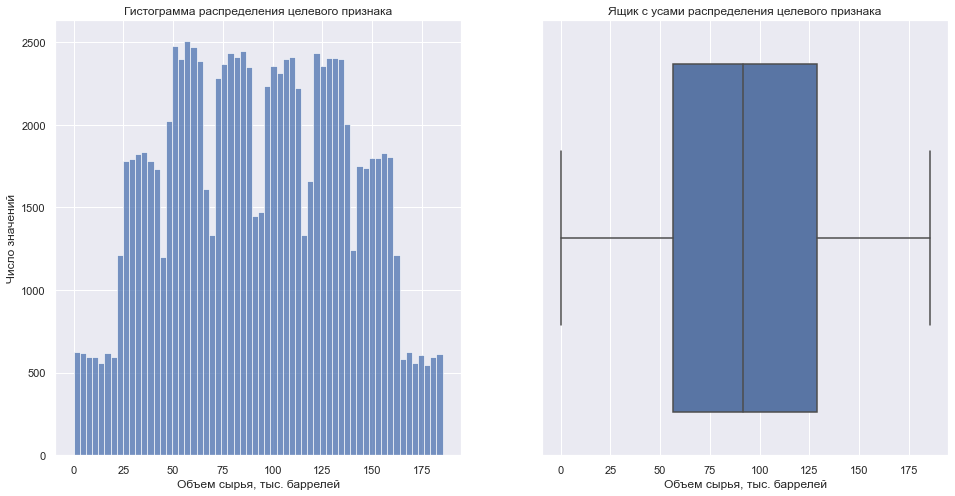

Основные статистические характеристики целевого признака:


count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64

In [9]:
describe_df(df_geo_0)

Медианное значение объема запасов нефти в датафрейме `df_geo_0` (далее регион №1) составляет 92 тыс. баррелей. Максимальное значение объемов 185 тыс. баррелей. Вид распределения представляет собой совокупность пиков, скорее всего эти пики представляют собой определенные районы месторождения в данном регионе. Самое большое число месторождений содержит запасы в пределах от 50 до 125 тыс. баррелей.

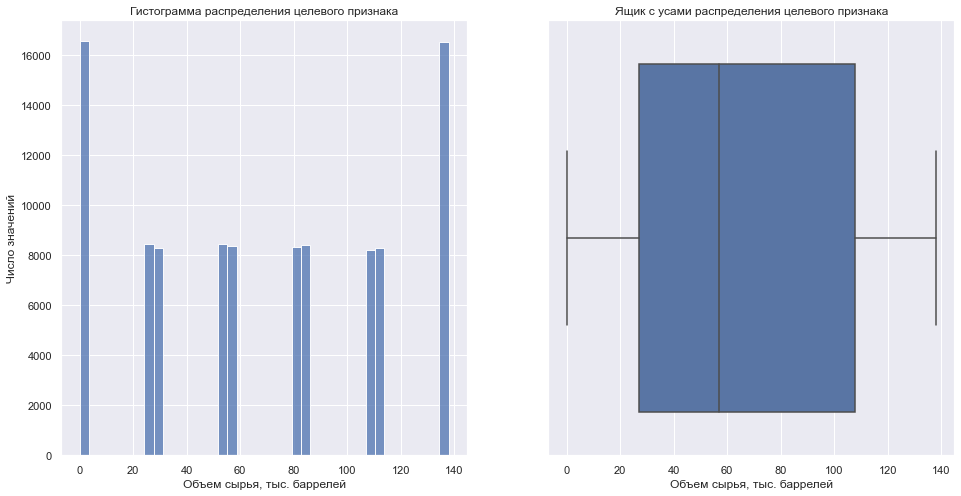

Основные статистические характеристики целевого признака:


count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64

In [10]:
describe_df(df_geo_1)

Медианное значение объема запасов нефти в датафрейме `df_geo_1` (далее регион №2) составляет 57 тыс. баррелей. Максимальное значение объемов 138 тыс. баррелей. Вид распределения также представляет собой совокупность пиков, но распределение значений достаточно странное. В регионе много очень богатых и практически пустых скважин.

In [11]:
( df_geo_0['product'].sum() - df_geo_1['product'].sum() ) * 100 / df_geo_1['product'].sum()

34.398837631674525

Суммарный объем запасов в регионе №1 превосходит суммарный объем запасов в регионе №2 на 34%.

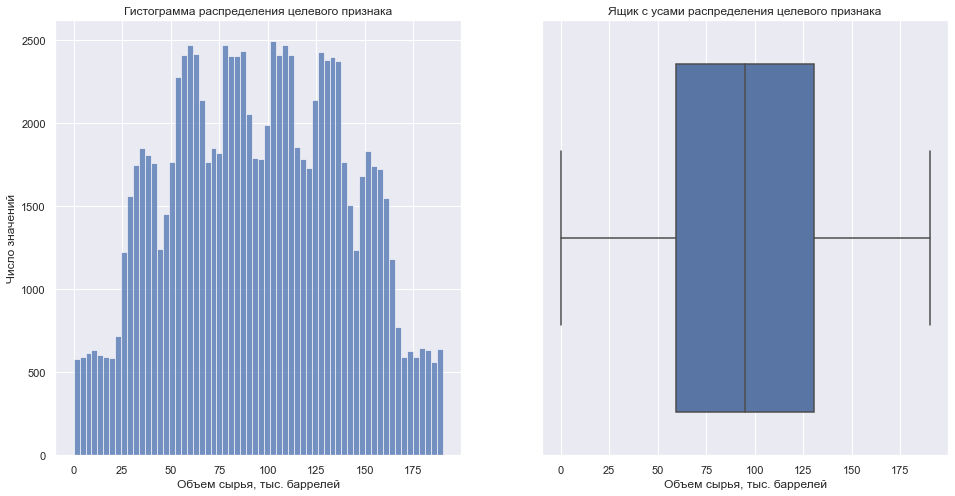

Основные статистические характеристики целевого признака:


count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64

In [12]:
describe_df(df_geo_2)

Медианное значение объема запасов нефти в датафрейме `df_geo_2` (далее регион №3) составляет 95 тыс. баррелей. Максимальное значение объемов 190 тыс. баррелей. Вид распределения схож с распределением региона №1. Регион №3 выглядит как самый богатый по объемам. Сравним объемы относительно регион №1:

In [13]:
( df_geo_2['product'].sum() - df_geo_0['product'].sum() ) * 100 / df_geo_0['product'].sum()

2.702702702702722

Суммарный объем запасов в регионе №3 превосходит суммарный объем запасов в регионе №1 на 2.7%.

Вычсилим также суммарные значения объемов сырья в каждом районе (в тыс. баррелей):

In [14]:
round(df_geo_0['product'].sum(), 3), round(df_geo_1['product'].sum(), 3), round(df_geo_2['product'].sum(), 3)

(9250000.0, 6882500.0, 9500000.0)

И средние запасы (в тыс. баррелей):

In [15]:
round(df_geo_0['product'].mean(), 3), round(df_geo_1['product'].mean(), 3), round(df_geo_2['product'].mean(), 3)

(92.5, 68.825, 95.0)

Так как данные в признаках синтетические и в условии задачи сказано, что все признаки значимы для модели - смотреть их распределение не будем.

Запишем признаки в соответствующие датафреймы с помощью функции:

In [16]:
def get_features(df):
    features = df.drop(['product', 'id'], axis=1).copy()
    target = df['product'].copy()
    return features, target

In [17]:
features_geo_0, target_geo_0 = get_features(df_geo_0)

In [18]:
features_geo_1, target_geo_1 = get_features(df_geo_1)

In [19]:
features_geo_2, target_geo_2 = get_features(df_geo_2)

Проверим размерность созданных датафреймов:

In [20]:
def get_features_shape(features, target):
    print('Размерность features: {} и target: {}'.format(features.shape, target.shape))

In [21]:
get_features_shape(features_geo_0, target_geo_0)

Размерность features: (100000, 3) и target: (100000,)


In [22]:
get_features_shape(features_geo_1, target_geo_1)

Размерность features: (100000, 3) и target: (100000,)


In [23]:
get_features_shape(features_geo_2, target_geo_2)

Размерность features: (100000, 3) и target: (100000,)


Для фиксации случайности запишем переменную `SEED` и `NP_SEED` для `numpy.RandomState`:

In [24]:
SEED = 12345

In [25]:
NP_SEED = np.random.RandomState(SEED)

Разделим каждый датасет на обучающую и тестовую выборки в отношении 1:4 с помощью функции:

In [26]:
def get_test_and_train(features, target):
    features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                                target, 
                                                                                train_size=0.75,
                                                                                random_state=SEED)
    return features_train, features_test, target_train, target_test

In [27]:
features_train_geo_0, features_test_geo_0, target_train_geo_0, target_test_geo_0 = get_test_and_train(features_geo_0, 
                                                                                                      target_geo_0)

In [28]:
features_train_geo_1, features_test_geo_1, target_train_geo_1, target_test_geo_1 = get_test_and_train(features_geo_1, 
                                                                                                      target_geo_1)

In [29]:
features_train_geo_2, features_test_geo_2, target_train_geo_2, target_test_geo_2 = get_test_and_train(features_geo_2, 
                                                                                                      target_geo_2)

Теперь масштабируем данные с помощью стандартизации. Все признаки численные, запишем список с названиями признаков:

In [30]:
numeric = ['f0', 'f1', 'f2']

Создадим объект структуры для стандартизации данных `StandardScaler` библиотеки `sklearn`:

In [31]:
scaler = StandardScaler()

Настроим созданый объект для обучающей и тестовой выборки и масштабируем признаки каждого датафрейма (раздельно по тестовой и обучающей выборке):

In [32]:
def standartized(features_train, features_test, numeric):
    features_train[numeric] = scaler.fit_transform(features_train[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    return features_train, features_test

In [33]:
features_train_geo_0, features_test_geo_0 = standartized(features_train_geo_0, features_test_geo_0, numeric)

In [34]:
features_train_geo_1, features_test_geo_1 = standartized(features_train_geo_1, features_test_geo_1, numeric)

In [35]:
features_train_geo_2, features_test_geo_2 = standartized(features_train_geo_2, features_test_geo_2, numeric)

Проверим масштабирование признаков, выведем первые две строки каждого датафрейма с признаками:

In [36]:
features_train_geo_0.head(2)

,f0,f1,f2
27212,-0.544828,1.390264,-0.094959
7866,1.455912,-0.480422,1.209567


In [37]:
features_train_geo_1.head(2)

,f0,f1,f2
27212,-0.850855,0.624428,0.296943
7866,1.971935,1.832275,0.294333


In [38]:
features_train_geo_2.head(2)

,f0,f1,f2
27212,-0.526160,0.776329,-0.400793
7866,-0.889625,-0.404070,-1.222936


Признаки масштабированы.

## Вывод

Данные загружены, первый взяглд на них выполнен. Предобработка данных не требуется, дубликатов или пропусков данных не обнаружено.

Произведено исследование значений целевого признака каждого датасета (региона). Вид распределения представляет собой совокупность пиков, скорее всего это определенные районы месторождений (богатые и бедные). По суммарным объемам запасов лидирует регион №3 (датафрейм `df_geo_2`, суммарный объем 9.5 млрд. баррелей), за ним идет регион №1 (`df_geo_0`, суммарный объем 9.25 млрд. баррелей). Регион №2 (`df_geo_1`) имеет самые низкие суммарные объемы - 6.9 млрд. баррелей.

Таблица 1 - Средние и суммарные запасы сырья по регионам.

|Регион, №|Суммарные запасы, млрд баррелей |Средение запасы, тыс баррелей|
|-------------|----------------|---------------|
|1|9.25|92.5|
|2|6.90|68.8|
|3|9.50|95.0|



Целевой признак каждого региона был записан в соответствующий датафрейм: `target_geo_0`, `target_geo_1`, `target_geo_2`. А остальные признаки в датафреймы: `features_geo_0`, `features_geo_1`, `features_geo_2`. После чего данные были разбиты на обучающую и тестовую выборки в соотношении 1:4. 

Признаки были масштабированы с помощью стандартизации данных раздельно по обучающей и тестовой выборке и записаны в соответствующие датафреймы для дальнейшей работы.

## Обучение и проверка модели<a id='2'></a>

Напишем функцию для обучения и получения предсказания и *RMSE* каждой модели:

In [39]:
def linear_regression(features_train, features_test, target_train, target_test):
    model = LinearRegression()
    model.fit(features_train, target_train)
    prediction_train = model.predict(features_train)
    print('RMSE на обучающей выборке:', mean_squared_error(prediction_train, target_train, squared=False))
    prediction_test = model.predict(features_test)
    print('RMSE на отложенной выборке:', mean_squared_error(prediction_test, target_test, squared=False))
    return prediction_test

In [40]:
pred_geo_0 = linear_regression(features_train_geo_0, features_test_geo_0, target_train_geo_0, target_test_geo_0)

RMSE на обучающей выборке: 37.72999219904026
RMSE на отложенной выборке: 37.5794217150813


In [41]:
pred_geo_1 = linear_regression(features_train_geo_1, features_test_geo_1, target_train_geo_1, target_test_geo_1)

RMSE на обучающей выборке: 0.8894720773917386
RMSE на отложенной выборке: 0.8930992867756167


In [42]:
pred_geo_2 = linear_regression(features_train_geo_2, features_test_geo_2, target_train_geo_2, target_test_geo_2)

RMSE на обучающей выборке: 40.06425978832384
RMSE на отложенной выборке: 40.02970873393434


Создадим пустые модельи линейной регрессии для каждого региона:

Посмотрим средний запас предсказанного сырья:

In [43]:
pred_geo_0.mean()

92.59256778438035

In [44]:
pred_geo_1.mean()

68.728546895446

In [45]:
pred_geo_2.mean()

94.96504596800489

*RMSE* модели для региона №2 имеет самое низкое значение. При прогнозе, мы в среднем ошибаемся на 0.9 тыс баррелей. С региона №1 и №3 ситуация намного хуже, при прогнозе мы ошибаемся на 38 и 40 тыс. баррелей соответственно. В прогнозировании средних запасов модели для всех регионов показывают отличный результат.

## Вывод

Для каждого региона была построена и обучена модель линейной регрессии. Прогнозируемые средние запасы сырья и *RSME* моделей для каждого региона представлены в таблице 2.

Таблица 2 - Предсказания модели, истинные значения и *RMSE* каждой модели

|Модель для региона, №| Предсказанное значение среднего запаса сырья, тыс. баррелей|Истинное значение среднего запаса сырья, тыс. баррелей | *RMSE* модели|
|---------------------|------------------------------------------------------------|------------------------------------------------------------|------------|
|1|92.6|92.5|37.6|
|2|68.8|68.8|0.9|
|3|95.0|95.0|40.0|

Модель выглядит очень хорошо для региона №2, для остальных регионов модель, в среднем, ошибается на 39 тыс. баррелей.

## Подготовка к расчёту прибыли<a id='3'></a>

Запишем константы для расчета прибыли из условия задачи, а именно:

- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Доход с каждой единицы продукта составляет 450 тыс. рублей (с каждой тысячи баррелей).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

In [46]:
BUDGET_FOR_BOREHOLES = 10 ** 10
REVENUE_FOR_THOUSAND_BARREL = 450 * 10 ** 3
NUMBER_OF_EXPLORATION = 500
NUMBER_OF_BOREHOLES = 200

In [47]:
REVENUE_FOR_THOUSAND_BARREL

450000

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Бюджет на разработку одной скважины составляет:

In [48]:
BUDGET_FOR_ONE_BOREHOLE = BUDGET_FOR_BOREHOLES / NUMBER_OF_BOREHOLES

In [49]:
BUDGET_FOR_ONE_BOREHOLE

50000000.0

Тогда необходимый объем сырья для безубыточной разработки скважины:

In [50]:
NECESSERY_VOLUME = BUDGET_FOR_ONE_BOREHOLE / REVENUE_FOR_THOUSAND_BARREL

In [51]:
NECESSERY_VOLUME

111.11111111111111

Сравним его с средними объемами запасов сырья в регионах:

In [52]:
def difference_mean(df):
    print('{:.2%}'.format( (df['product'].mean() - NECESSERY_VOLUME ) / NECESSERY_VOLUME ))

In [53]:
difference_mean(df_geo_0)

-16.75%


In [54]:
difference_mean(df_geo_1)

-38.06%


In [55]:
difference_mean(df_geo_2)

-14.50%


Необходимый объем сырья для безубыточной работы скажины весомо превышает средние запасы сырья во всех регионах. 

## Вывод

Все необходимые константы для дальнейшего расчета прибыли записаны, также вычислен необходимый объем сырья для безубыточной работы скважины, он составляет **111.1 тыс. баррелей**.

Необходимый объем сырья для безубыточной работы скважины был сопоставлен со средними запасами сырья в каждом из регионов, он *весомо превышает* средние запасы сырья во всех регионах.

Таблица 3 - средние запасы сырья в регионах в сравнении с необходимым объемом сырья для безубыточной работы скважины

|Регион, №| Средние запасы сырья, тыс. баррелей | Необходимый объем сырья для безубыточной разработки скважины, тыс. баррелей | Разница среднего и необходимого, %|
|---------|-------------------------------------|---------------------------------------------------------------------|---------------|
|1|92.5|     | -16.75
|2|68.8|111.1| -38.06
|3|95.0|     | -14.50



## Расчёт прибыли и рисков<a id='4'></a>

Напишем функцию для расчета прибыли для дальнейшних расчетов прибыли и рисков. Сначала отберем скважины (`NUMBER_OF_BOREHOLES`) с наибольшими значениями предсказаний, затем просуммируем объемы сырья этих скважин и рассчитаем прибыль для полученного объема сырья.

In [56]:
def profit(prediction, target):
    pred_sorted = pd.Series(prediction).sort_values(ascending=False).head(NUMBER_OF_BOREHOLES)
    selected = target.iloc[pred_sorted.index]
    return REVENUE_FOR_THOUSAND_BARREL * selected.sum() - BUDGET_FOR_BOREHOLES

Прибыль (округлив до целого) для скважин с максимальными объемами предсказаний для каждого из регионов:

In [57]:
round(profit(pred_geo_0, target_test_geo_0))

3320826043

In [58]:
round(profit(pred_geo_1, target_test_geo_1))

2415086697

In [59]:
round(profit(pred_geo_2, target_test_geo_2))

2710349964

Наибольшая максимальная (для скважин с предсказанными максимальными объемами сырья) прибыль в регионе №1 и составляет - 3.3 млрд. рублей, затем идет регион №1 с максимальной прибылью в 2,7 млрд. рублей. Наименьшая максимальная прибыль в регионе №1 и составляет - 2,4 млрд. рублей.

В реальности же, мы не выбираем 200 лучших скважен из ста тысяч, поэтому прибыль может быть намного меньше.

Применим технику *bootstrap* для 1000 выборок, чтобы найти распределение возможной прибыли для каждого региона. В бутстрепе будем моделировать исследование каждого региона согласно условию задачи: "при разведке региона исследуют 500 точек (`NUMBER_OF_EXPLORATION`), из которых с помощью машинного обучения выбирают 200 лучших (`NUMBER_OF_BOREHOLES`) для разработки". Последнее у нас уже учтено в функции для подсчета прибыли, а исследование 500 точек будем моделировать бутстрепом. 

In [60]:
def bootstrap(prediction, target, samples):
    values = []
    target = target.reset_index(drop=True)
    for _ in range(samples):
        target_subsample = target.sample(NUMBER_OF_EXPLORATION,
                                         random_state=NP_SEED,
                                         replace=True)
        pred_subsample = pd.Series(prediction).iloc[target_subsample.index]
        
        target_subsample = target_subsample.reset_index(drop=True)
        pred_subsample = pred_subsample.reset_index(drop=True)
        
        values.append(profit(pred_subsample, target_subsample))
        
    values = pd.Series(values)
    mean = values.mean()
    confidence_interval = (values.quantile(0.025), values.quantile(0.975))
    
    return mean, values, confidence_interval

In [61]:
mean_geo_0, values_geo_0, confidence_interval_geo_0 = bootstrap(pred_geo_0, target_test_geo_0, 1000)

In [62]:
print('Средняя прибыль в регионе №1:', mean_geo_0, '95-% доверительный интервал:', confidence_interval_geo_0)

Средняя прибыль в регионе №1: 396164984.802371 95-% доверительный интервал: (-111215545.89049526, 909766941.5534226)


In [63]:
mean_geo_1, values_geo_1, confidence_interval_geo_1 = bootstrap(pred_geo_1, target_test_geo_1, 1000)

In [64]:
print('Средняя прибыль в регионе №1:', mean_geo_1, '95-% доверительный интервал:', confidence_interval_geo_1)

Средняя прибыль в регионе №1: 461155817.27723986 95-% доверительный интервал: (78050810.7517417, 862952060.2637234)


In [65]:
mean_geo_2, values_geo_2, confidence_interval_geo_2 = bootstrap(pred_geo_2, target_test_geo_2, 1000)

In [66]:
print('Средняя прибыль в регионе №1:', mean_geo_2, '95-% доверительный интервал:', confidence_interval_geo_2)

Средняя прибыль в регионе №1: 392950475.17060375 95-% доверительный интервал: (-112227625.37857565, 934562914.5511636)


Средняя прибыль во втором регионе получилась больше, чем в других регионах (461 млн. руб.). Несмотря на то, что средние запасы там самые низкие, во втором регионе больше "богатых" скважин. В регионах №1 и №3 получили практически равное значение средней прибыли: 395.8 и 392.9 млн соответственно. Для первого и третьего региона в 95%-ый доверительный интервал входят отрицательные значения прибыли (убытки). 

Построим гистограммы смоделированных распределений прибыли обозначив на них точку безубытка (красная линия) и 95%-ый доверительный интервал для средней выручки (зеленые линии), а также среднее значение прибыли (синяя линия).

In [67]:
def get_hist(mean, values, confidence_interval):
    plt.figure(figsize=(16, 8))
    sns.histplot(values, alpha=0.4).set(xlabel='Прибыль, руб.', 
                                        ylabel='Число значений',
                                        title='Гистограмма смоделированного распределения прибыли техникой bootstrap')
    plt.axvline(confidence_interval[0], 0, color='g', marker='.')
    plt.axvline(confidence_interval[1], 0, color='g')
    plt.axvline(mean, 0, color='b')
    plt.axvline(0, 1, 0, color='r')
    plt.annotate('Точка безубыточности', (10**7, 40), rotation=90)

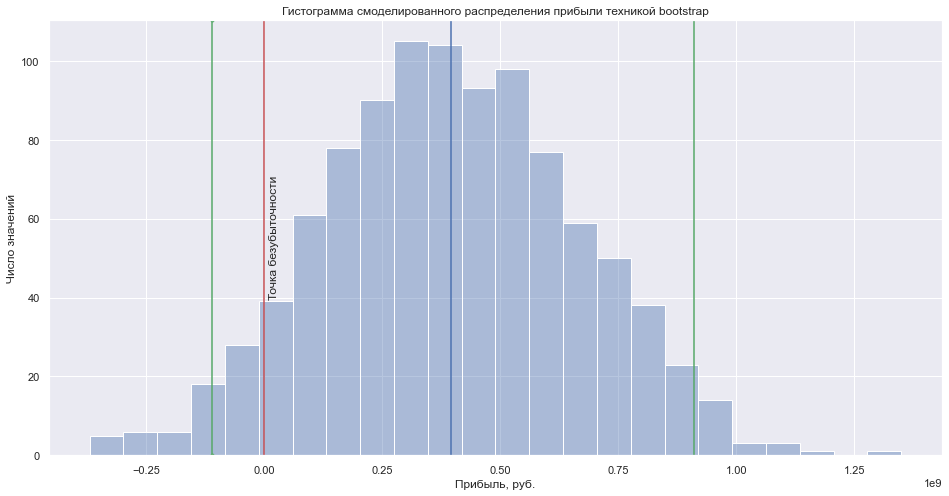

In [68]:
get_hist(mean_geo_0, values_geo_0, confidence_interval_geo_0)

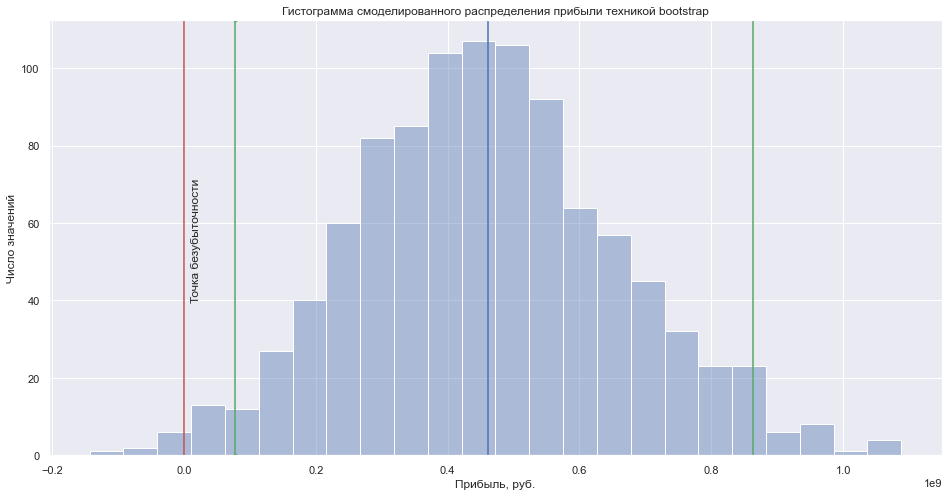

In [69]:
get_hist(mean_geo_1, values_geo_1, confidence_interval_geo_1)

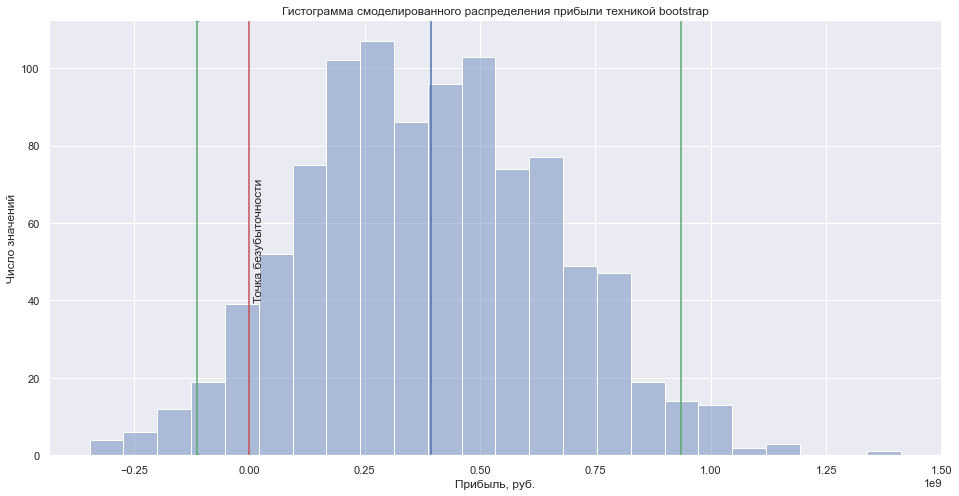

In [70]:
get_hist(mean_geo_2, values_geo_2, confidence_interval_geo_2)

По гистограммам видно, что во всех трех случаях есть риск убытков, однако, для второго региона средняя прибыль при доверительной вероятности $P=0.95$ лежит в интервале от 58.2 до 848.7 млн. Оценим убытки:

In [71]:
print('Регион №1, вероятность убытков: {:.2%}'.format((values_geo_0 < 0).mean()))

Регион №1, вероятность убытков: 6.90%


In [72]:
print('Регион №2, вероятность убытков: {:.2%}'.format((values_geo_1 < 0).mean()))

Регион №2, вероятность убытков: 0.70%


In [73]:
print('Регион №3, вероятность убытков: {:.2%}'.format((values_geo_2 < 0).mean()))

Регион №3, вероятность убытков: 6.50%


Вероятность убытков при разработке скважин в регионах №1 и №3 6.9 и 6.5% соответственно, а в регионе №2 не превышает 0.7%.

## Вывод

В данном разделе были вычислены: максимально возможная выручка в каждом регионе, средняя выручка в каждом регионе, 95%-ый доверительный интервал для средней выручки в каждом регионе, а также риск убытков при разработке скважин. Для расчета последних была применена техника *bootstrap* с 1000 подвыборками. Полученные результаты представлены в таблице 4.

Таблица 4 - результаты расчета выручки, приыбли, риска убытков

|Регион, №|Максимально возможная прибыль, млрд. руб. | Средняя прибыль (bootstrap), млн. руб.| 95%-ый Доверительный интервал для средней прибыли, млн. руб. | Риск убытков, %|
|-|-----|-------|-------------------|-----|
|1|3.320|396.164|-111.215 ÷ 909.766 | 6.9%|
|2|2.415|461.156|780.508 ÷ 862.952   |0.7%|
|3|2.710|392.950|-112.227 ÷ 934.562  |6.5%|



Таким образом наибольшая средняя прибыль наблюдается при разработке региона №2, также регион имеет самый низкий риск убытков, возможные риски убытков не превышают 0.7% в рамках проведенного исследования. Построенная модель линейной регрессии для региона №2 является более точной, и ошибается, в среднем, на 0.9 тыс. баррелей. *Для разработки скважин рекомендуется выбрать регион №2.*

## Общий вывод<a id='5'></a>

В ходе разработки проекта были загружены и исследованы исходные данные по трем предпологаемым регионам для разработки нефтяных скважин. Дубликатов и пропусков не обнаружено, предобработка данных не потребовалась. В ходе работы соблюдались все поставленные задчаей условия.

Было произведено исследование значений целевого признака каждого датасета (региона). Вид распределения представляет собой совокупность пиков, скорее всего это определенные районы месторождений (богатые и бедные). По суммарным объемам запасов лидирует регион №3 (датафрейм `df_geo_2`, суммарный объем 9.5 млрд. баррелей), за ним идет регион №1 (`df_geo_0`, суммарный объем 9.25 млрд. баррелей). Регион №2 (`df_geo_1`) имеет самые низкие суммарные объемы - 6.9 млрд. баррелей.

В условиях задачи сказано, что данные в признаках синтетические и физика данных неизвестна, поэтому распределение данных в рамках данной работы не проводилось. Средние и суммарные запасы сырья в регионах представлено в таблице 1.

Таблица 1 - Средние и суммарные запасы сырья по регионам.

|Регион, №|Суммарные запасы, млрд баррелей |Средение запасы, тыс баррелей|
|-------------|----------------|---------------|
|1|9.25|92.5|
|2|6.90|68.8|
|3|9.50|95.0|

Для построения модели предсказаний, данные были разбиты на обучающую и тестовую выборки в соотношении 1:4 и масштабированы с помощью стандартизации данных раздельно по обучающей и тестовой выборке. В качестве алгоритма модели согласно условию задачи была использована линейная регрессия. Модель была обучена линейной регрессии. Прогнозируемые средние запасы сырья и *RSME* моделей для каждого региона представлены в таблице 2.

Таблица 2 - Предсказания модели, истинные значения и *RMSE* каждой модели

|Модель для региона, №| Предсказанное значение среднего запаса сырья, тыс. баррелей|Истинное значение среднего запаса сырья, тыс. баррелей | *RMSE* модели|
|---------------------|------------------------------------------------------------|------------------------------------------------------------|------------|
|1|92.6|92.5|37.6|
|2|68.8|68.8|0.9|
|3|95.0|95.0|40.0|

Модель выглядит очень хорошо для региона №2 (ошибается, в среднем, на 0.9 тыс баррелей), для остальных регионов модель, в среднем, ошибается на 39 тыс. баррелей. Таким образом для региона №2 мы имеем более точный прогноз запасов сырья.

Далее был вычислен необходимый объем сырья для безубыточной работы скажины, который составил 111.1 тыс. баррелей. Таким образом необходимый объем сырья для безубыточной работы скажины *весомо превышает*  средние объемы сырья в каждом регионе. Сравнение средних объемов представлено в таблице 3.


Таблица 3 - средние запасы сырья в регионах в сравнении с необходимым объемом сырья для безубыточной работы скважины

|Регион, №| Средние запасы сырья, тыс. баррелей | Необходимый объем сырья для безубыточной разработки скважины, тыс. баррелей | Разница среднего и необходимого, %|
|---------|-------------------------------------|---------------------------------------------------------------------|---------------|
|1|92.5|     | -16.75
|2|68.8|111.1| -38.06
|3|95.0|     | -14.50

В заключительной части работы были вычислены: максимально возможная выручка в каждом регионе, средняя выручка в каждом регионе, 95%-ый доверительный интервал для средней выручки в каждом регионе, а также риск убытков при разработке скважин. Для расчета последних была применена техника *bootstrap* с 1000 подвыборками. Полученные результаты представлены в таблице 4.

Таблица 4 - результаты расчета выручки, приыбли, риска убытков

|Регион, №|Максимально возможная прибыль, млрд. руб. | Средняя прибыль (bootstrap), млн. руб.| 95%-ый Доверительный интервал для средней прибыли, млн. руб. | Риск убытков, %|
|-|-----|-------|-------------------|-----|
|1|3.320|396.164|-111.215 ÷ 909.766 | 6.9%|
|2|2.415|461.156|780.508 ÷ 862.952   |0.7%|
|3|2.710|392.950|-112.227 ÷ 934.562  |6.5%|


Из таблицы видно, что разработка скважин в регионе №2 является наиболее преспективной, судя по наибольшей средней прибыли (461.156 млн. руб.) среди представленных регионов. Важно также отметить, что модель предсказаний для региона №2 является самой точной по метрике *RMSE*. Регион №2 также имеет наименьший риск убытков при разработке в нем скважин - 0.7%.

Для разработки нефтяных скважин рекомендуется разрабатывать регион №2 (исходный файл `geo_data_1.csv`).